# Stable Diffusion v 1.4 with 🤗 Diffusers v 0.3.0
Implement Stable Diffusion via Huggingface Diffusers

In [1]:
# Install dependencies
%pip install -Uq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
with open('huggingface-access-tokens.txt', 'r') as f:
    TOKEN = f.readlines()[0]

To retrive the access tokens, refer to [this documentation](https://huggingface.co/docs/hub/security-tokens).

[Link to get token](https://huggingface.co/settings/tokens).

In [2]:
import diffusers
print("diffusers version: ", diffusers.__version__)

diffusers version:  0.3.0


In [3]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## StableDiffusionPipeline
Ready-to-go pipeline that requires minimal input

In [4]:
%%capture
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    use_auth_token = TOKEN,
    revision = "fp16" if torch_device != "cpu" else None,
    torch_dtype = torch.float16 if torch_device != "cpu" else None)

pipe.to(torch_device)

pipe.enable_attention_slicing() # attention optimization for less memory usage

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [6]:
import random

def run(prompt = "a photograph of an astronaut riding a horse",
        seed = random.randint(0, 10e6),
        guidance_scale = 7.5):
    '''
    Generate an image with custom parameters using the pipeline
    '''
    with torch.autocast(torch_device):
        image = pipe(prompt,
                     guidance_scale = 7.5,
                     generator = torch.Generator(torch_device).manual_seed(seed)
                    ).images[0]
    return image

  0%|          | 0/51 [00:00<?, ?it/s]

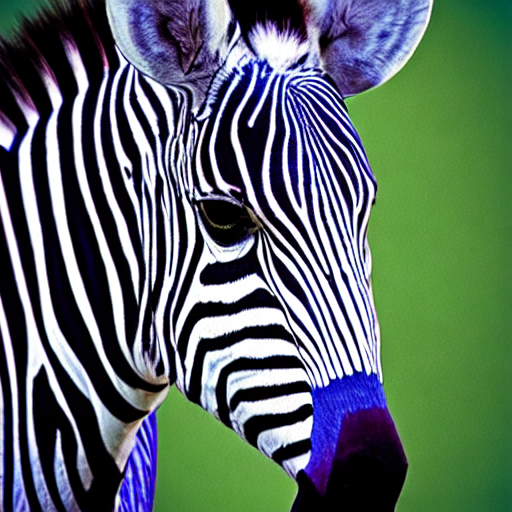

In [7]:
run("photograph, zebra, blue")

## Explain the image generation process with diffusers-interpret

In [5]:
from diffusers_interpret import StableDiffusionPipelineExplainer

# Pass pipeline to the explainer class
explainer = StableDiffusionPipelineExplainer(pipe, gradient_checkpointing=True)

  0%|          | 0/51 [00:00<?, ?it/s]

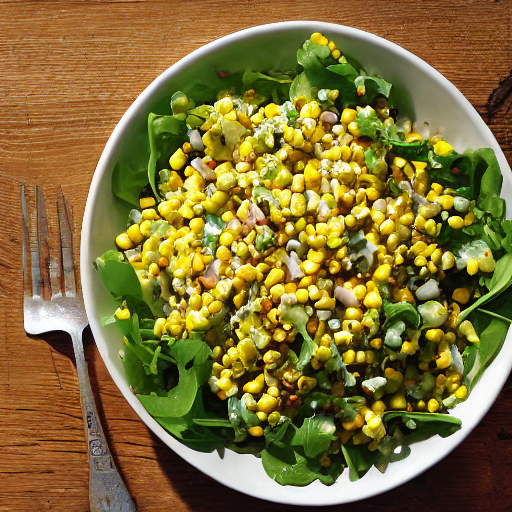

In [24]:
prompt = "photograph, piggy, corn salad"

with torch.autocast(torch_device):
    output = explainer(prompt,
                       # height = 448,
                       # width = 448,
                       generator = torch.Generator(torch_device).manual_seed(42),
                       guidance_scale=7.5,
                       num_inference_steps=50,
                       n_last_diffusion_steps_to_consider_for_attributions=0
                      )

output.image

In [31]:
import pickle
with open('output.pkl', 'wb') as handle:
    pickle.dump(output, handle, protocol = pickle.HIGHEST_PROTOCOL)

Preview the image generation process with an image slider. Note, the upper cell does not seem to work here. The 2nd cell downloads the preview as html.

In [ ]:
output.all_images_during_generation.show()

In [28]:
import os, shutil, diffusers_interpret
shutil.copy2(os.path.join(os.path.dirname(diffusers_interpret.__file__), "dataviz", "image-slider", "final.html"), '.')

'./final.html'

To view token attributions, make sure to adjust the `n_last_diffusion_steps_to_consider_for_attributions` argument.

In [18]:
output.normalized_token_attributions